In [1]:
"""
lying down
lounging
walking
"""

import torch
from torch import nn
from lib.nursing import *
from lib.utils import *
from lib.models import ResNet
def evaluate_2(dataloader,model,criterion,DEVICE=DEVICE):
    model.eval()
    with torch.no_grad():
        y_true = torch.Tensor()
        y_pred = torch.Tensor()
        y_logits = torch.Tensor()
        y_embedding = torch.Tensor()
        loss_total = 0
        for (Xi,yi) in tqdm(dataloader):
            y_true = torch.cat([y_true,yi.round()])
            
            logits = model(Xi)
            loss = criterion(logits,yi)
            loss_total += loss.item()
            
            y_logits = torch.cat([y_logits,torch.sigmoid(logits).detach().cpu()])
            y_pred = torch.cat([y_pred,torch.sigmoid(logits).round().detach().cpu()])
            y_embedding = torch.cat([y_embedding,model(Xi,classification=False).squeeze(2).detach().cpu()])

            
    model.train()
    return loss_total/len(dataloader),metrics(y_true,y_pred),y_true,y_pred,y_logits,y_embedding

In [2]:
# a single fold
foldi = 0
model = ResNet()
model.load_state_dict(torch.load(f'../projects/res_cv_{foldi}/best_model.pt'))
criterion = nn.BCEWithLogitsLoss()
train_idx = load_cv_train_idx(foldi=foldi)
X,y = load_and_window_nursing_list_for_convolution([train_idx[0]])

In [3]:
trainloader = DataLoader(TensorDataset(X,y),batch_size=32,shuffle=False)

In [4]:
loss,metric,y_true,y_pred,y_logits,y_embedding = evaluate_2(trainloader,model,criterion)

  0%|          | 0/975 [00:00<?, ?it/s]/home/andrew/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv1d(input, weight, bias, self.stride,
100%|██████████| 975/975 [00:07<00:00, 123.38it/s]


In [5]:
X = window_epoched_signal(y_embedding,windowsize=3,n_channels=128,zero_padding=True)
y = y_true
trainloader = DataLoader(TensorDataset(X,y),batch_size=32,shuffle=True)
devloader = DataLoader(TensorDataset(X,y),batch_size=32,shuffle=False)

In [6]:
test_idx = load_cv_test_idx(foldi=foldi)
X,y = load_and_window_nursing_list_for_convolution([test_idx[0]])
testloader = DataLoader(TensorDataset(X,y),batch_size=32,shuffle=False)
loss,metric,y_true,y_pred,y_logits,y_embedding = evaluate_2(testloader,model,criterion)
X = window_epoched_signal(y_embedding,windowsize=3,n_channels=128,zero_padding=True)
y = y_true
testloader = DataLoader(TensorDataset(X,y),batch_size=32,shuffle=False)

100%|██████████| 913/913 [00:07<00:00, 114.86it/s]


In [7]:
class Andrew(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.lstm = nn.LSTM(input_size=128,hidden_size=256,bidirectional=True)
        self.classifier = nn.Sequential(
            nn.Linear(in_features=512,out_features=32),
            nn.ReLU(),
            nn.Linear(32,1)
        )
    def forward(self,x):
        x = x.transpose(1,2)
        o,_ = self.lstm(x)
        x = self.classifier(o[:,-1,:])
        return x
model = Andrew()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [21]:
lossi = []
for epoch in range(3):
    for X,y in tqdm(trainloader):
        logits = model(X)
        loss = criterion(logits,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lossi.append(loss.item())

100%|██████████| 975/975 [00:30<00:00, 32.25it/s]


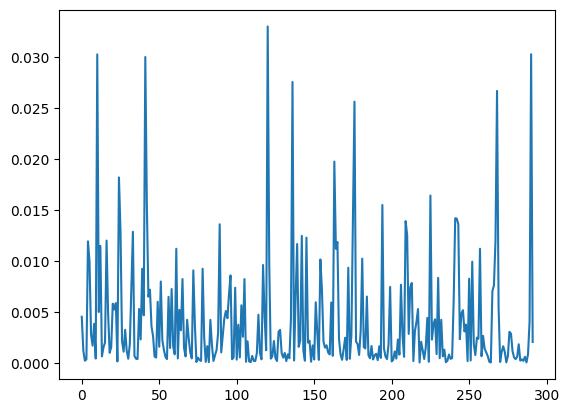

In [22]:
# plt.plot(lossi)
plt.plot(torch.tensor(lossi[:len(lossi) - len(lossi)%10]).view(-1,10).mean(axis=1))

In [23]:
loss,metric,y_true,y_pred_second,y_logits = evaluate(testloader,model,criterion)
print(loss)
print(metric)

100%|██████████| 913/913 [00:03<00:00, 271.43it/s]


0.14950555688654457
{'precision': 0.9516279909285371, 'recall': 0.816779435947333, 'f1': 0.8709033448068526}


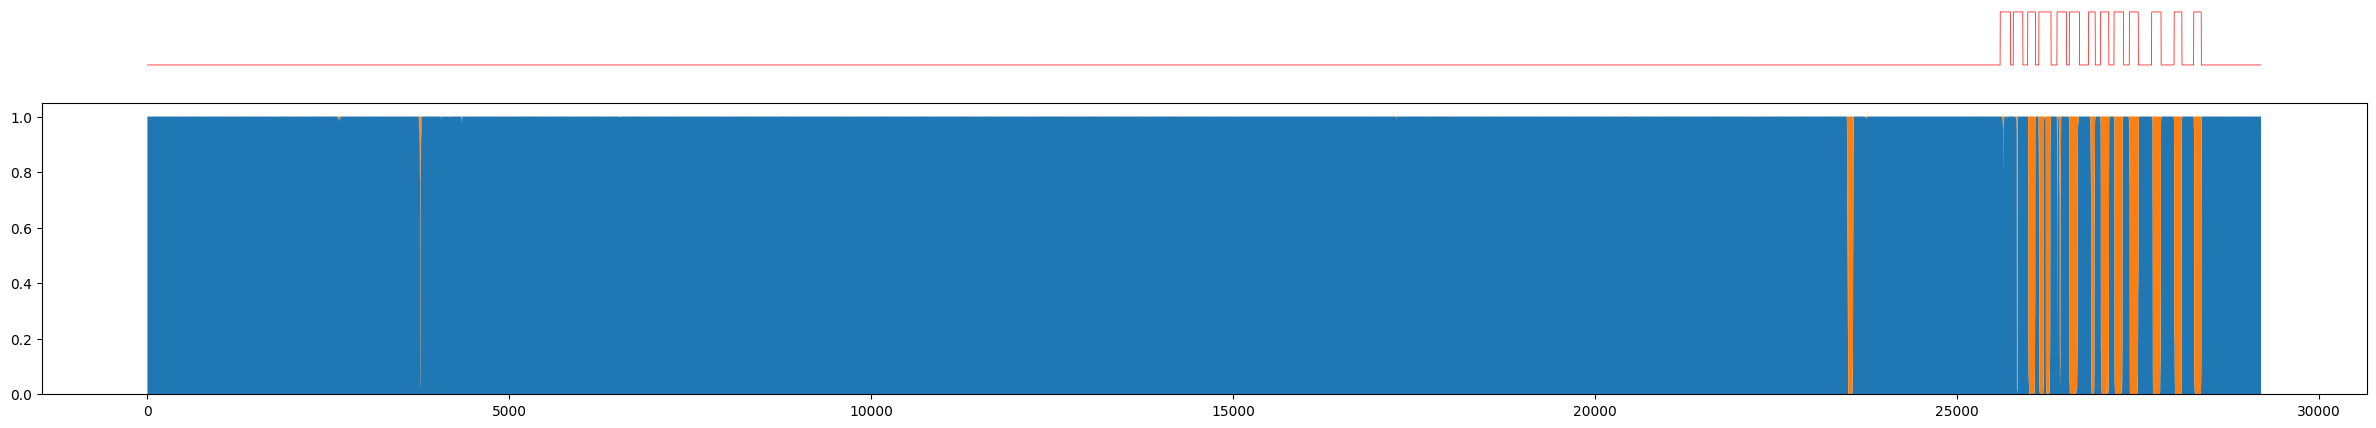

In [24]:
fig,axes = plt.subplots(nrows=2,ncols=1,figsize=(30,5),gridspec_kw={'height_ratios': [1,5]})
axes[0].plot(y_true,'r',linewidth=.5)
axes[0].axis('off')
plt.stackplot(torch.arange(len(y_logits)),torch.hstack([torch.ones_like(y_logits) - y_logits,y_logits]).T)
plt.savefig(f'logits.pdf',bbox_inches='tight')

In [25]:
f1_score(y_true,y_pred_second,average='macro')

0.8709033448068526

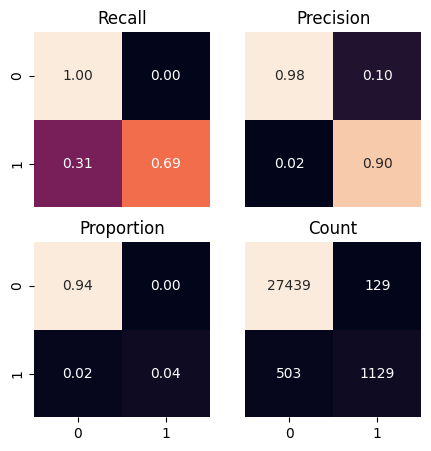

In [26]:
cm_grid(y_true,y_pred)

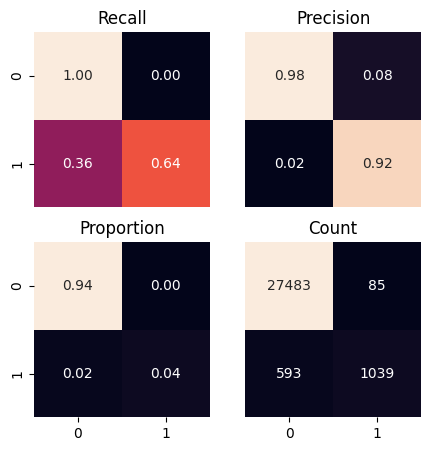

In [27]:
cm_grid(y_true,y_pred_second)

In [19]:
import plotly.express as px
X,y = load_nursing_by_index(test_idx[0])
df = pd.DataFrame(X.numpy())
df['y_true'] = y*10
df['y_pred'] = torch.cat([torch.zeros(101//2),y_pred.flatten().round(),torch.zeros(101//2)])*10
df['y_pred_second'] = torch.cat([torch.zeros(101//2),y_pred_second.flatten().round(),torch.zeros(101//2)])*10
fig = px.line(df)
fig.show(renderer='browser')